# Predicting Windpower with Windspeed

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/railsplitter_data.csv", usecols=['Time','MWh'])
windpower = np.array(dataframe.MWh).astype('float64')

# normalize
wind_max = np.max(windpower)
# norm = np.linalg.norm(windpower)
# windpower_norm = windpower/norm
windpower_norm = windpower/wind_max

In [3]:
# import weather data
weather_df = pd.read_csv("../data/lincoln_weatherdata.csv", parse_dates=True, usecols=['time','windspeed'])
startdate = pd.to_datetime(dataframe['Time'].iloc[0])
enddate = pd.to_datetime(dataframe['Time'].iloc[-1])
dates = (pd.to_datetime(weather_df['time']) >= startdate) & (pd.to_datetime(weather_df['time']) <= enddate)
windspeed_df = weather_df[dates]
windspeed_df

,time,windspeed
51631,2016-11-01 01:00:00,8.000000
51632,2016-11-01 02:00:00,9.000000
51633,2016-11-01 03:00:00,8.000000
51634,2016-11-01 04:00:00,7.000000
51635,2016-11-01 05:00:00,7.000000
...,...,...
74953,2019-06-30 19:00:00,1.666667
74954,2019-06-30 20:00:00,7.666667
74955,2019-06-30 21:00:00,2.000000
74956,2019-06-30 22:00:00,3.000000


### Check for missing data

In [4]:
windspeed_df.windspeed.isnull().values.any()

True

### Fill in missing values with interpolation

In [5]:
windspeed_df = windspeed_df.interpolate(method='linear')

### Check that missing data was filled in

In [6]:
windspeed_df.windspeed.isnull().values.any()

False

In [7]:
# normalize with maximum value
windspeed = np.array(windspeed_df.windspeed).astype('float64')
max_speed = np.max(windspeed)
windspeed_norm = windspeed/max_speed

In [8]:
windspeed_norm

array([0.25806452, 0.29032258, 0.25806452, ..., 0.06451613, 0.09677419,
       0.13709677])

In [9]:
X_in = np.concatenate([[windpower_norm[:len(windspeed)], windspeed_norm]], axis=1)

## Optimization begins here

In [10]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':8000}

In [11]:
futureTotal = params['future']
time_range = np.array(dataframe.Time)
hour_range = np.arange(0, len(time_range), 1)

In [12]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 7.41 seconds
This simulation took 0.12 minutes


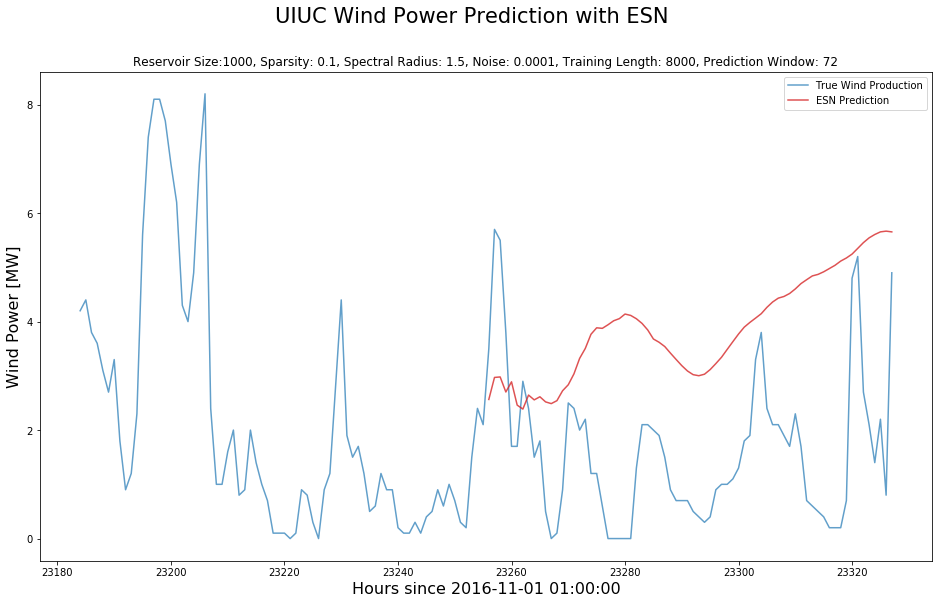

In [13]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],wind_max*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], wind_max*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.13098618508313625
rho = 0.5, noise = 0.0003, MSE=0.13033580791677402
rho = 0.5, noise = 0.0007, MSE=0.13438809813823868
rho = 0.5, noise = 0.001, MSE=0.1362157381444453
rho = 0.5, noise = 0.003, MSE=0.1476013287858719
rho = 0.5, noise = 0.005, MSE=0.15267158177158294
rho = 0.5, noise = 0.007, MSE=0.15421294966168286
rho = 0.5, noise = 0.01, MSE=0.1541553064864306
rho = 0.7, noise = 0.0001, MSE=0.1330729730488984
rho = 0.7, noise = 0.0003, MSE=0.130909609308038
rho = 0.7, noise = 0.0007, MSE=0.1308722060565308
rho = 0.7, noise = 0.001, MSE=0.1312382812860422
rho = 0.7, noise = 0.003, MSE=0.13290644498480925
rho = 0.7, noise = 0.005, MSE=0.13694845709843115
rho = 0.7, noise = 0.007, MSE=0.1404461121279019
rho = 0.7, noise = 0.01, MSE=0.14404006799110125
rho = 0.9, noise = 0.0001, MSE=0.13159659214512562
rho = 0.9, noise = 0.0003, MSE=0.1267187116527746
rho = 0.9, noise = 0.0007, MSE=0.12703547672527696
rho = 0.9, noise = 

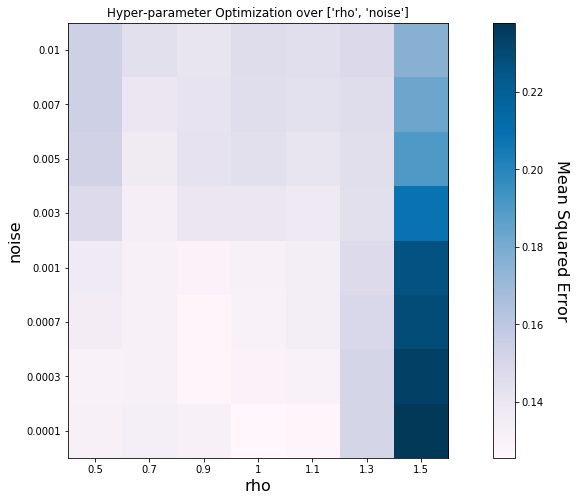

In [14]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

In [15]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

In [16]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)
        
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02} seconds.")
print(f"This simulation took {elapsed/60:0.02} minutes.")

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.12793562264271785
n_reservoir = 600, sparsity = 0.01, MSE=0.12824235148582805
n_reservoir = 600, sparsity = 0.03, MSE=0.12381313592668136
n_reservoir = 600, sparsity = 0.05, MSE=0.12787877850965165
n_reservoir = 600, sparsity = 0.1, MSE=0.1270961897141899
n_reservoir = 600, sparsity = 0.15, MSE=0.12649676579552122
n_reservoir = 600, sparsity = 0.2, MSE=0.12178360413374001
n_reservoir = 800, sparsity = 0.005, MSE=0.13538517279294468
n_reservoir = 800, sparsity = 0.01, MSE=0.12706967739834527
n_reservoir = 800, sparsity = 0.03, MSE=0.1277981372553351
n_reservoir = 800, sparsity = 0.05, MSE=0.12795919376272244
n_reservoir = 800, sparsity = 0.1, MSE=0.12387665253378219
n_reservoir = 800, sparsity = 0.15, MSE=0.12118348648190831
n_reservoir = 800, sparsity = 0.2, MSE=0.12592700508127325
n_reservoir = 1000, sparsity = 0.005, MSE=0.1677563264391055
n_reservoir = 1000, sparsity = 0.01, MSE=0.144131584203967

KeyboardInterrupt: 

In [ ]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

In [17]:
params['n_reservoir'] = 800
params['sparsity'] = 0.15

Optimizing over ['trainlen']:
trainlen = 4000, MSE=0.18274977914808546
trainlen = 4300, MSE=0.13075498030565705
trainlen = 4600, MSE=0.15085301165106468
trainlen = 4900, MSE=0.1286103188692989
trainlen = 5200, MSE=0.12731234422428306
trainlen = 5500, MSE=0.12770650392852353
trainlen = 5800, MSE=0.13817869834035765
trainlen = 6100, MSE=0.13876404716063226
trainlen = 6400, MSE=0.13965815099495776
trainlen = 6700, MSE=0.12523922666738324
trainlen = 7000, MSE=0.12224959023827482
trainlen = 7300, MSE=0.12244689018690535
trainlen = 7600, MSE=0.1220323165367507
trainlen = 7900, MSE=0.12308833409638838
trainlen = 8200, MSE=0.11926455879441884
trainlen = 8500, MSE=0.12061228955121085
trainlen = 8800, MSE=0.11934361628006883
trainlen = 9100, MSE=0.11917125608759928
trainlen = 9400, MSE=0.12190989274939341
trainlen = 9700, MSE=0.11969072840938247
trainlen = 10000, MSE=0.11750670580223496
trainlen = 10300, MSE=0.11696882055137467
trainlen = 10600, MSE=0.11923945287688163
trainlen = 10900, MSE=0.12

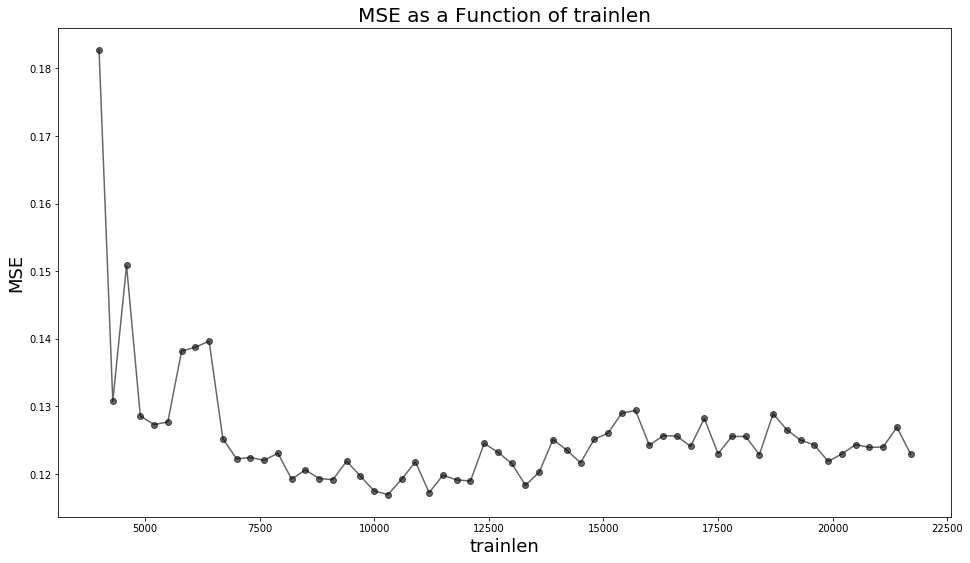

In [18]:
tic = time.perf_counter()
trainingLengths = np.arange(4000,22000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds.")
print(f"This simulation took {elapsed/60:0.02f} minutes.")

In [19]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt
print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 10300


### 5. Final Optimized ESN

In [20]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 3.92 seconds
This simulation took 0.07 minutes


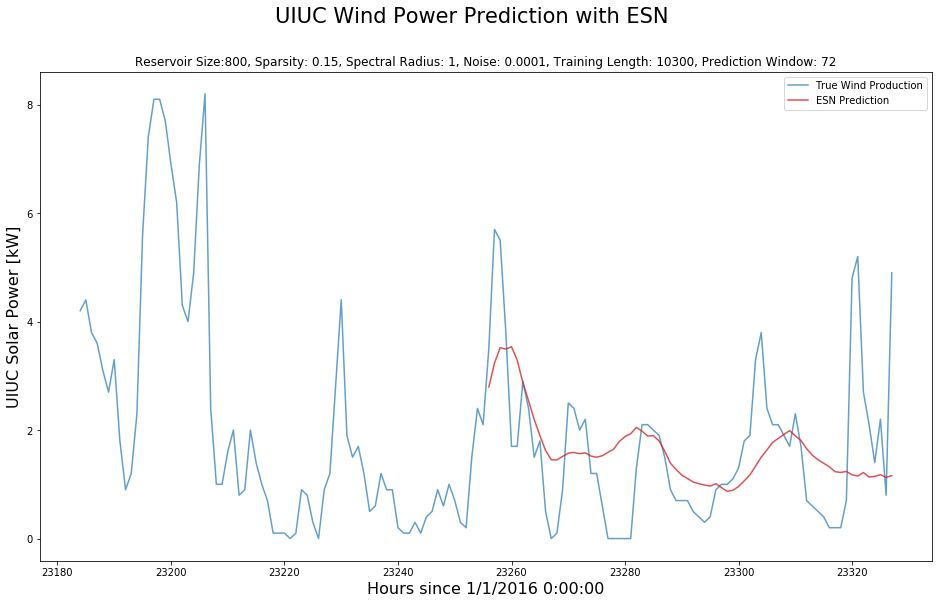

In [21]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Power [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
plt.plot(hour_range[-2*futureTotal:],wind_max*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], wind_max*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [26]:
pstring = param_string(params)
pstring

'Reservoir Size:800, Sparsity: 0.15, Spectral Radius: 1, Noise: 0.0001, Training Length: 10300, Prediction Window: 72'

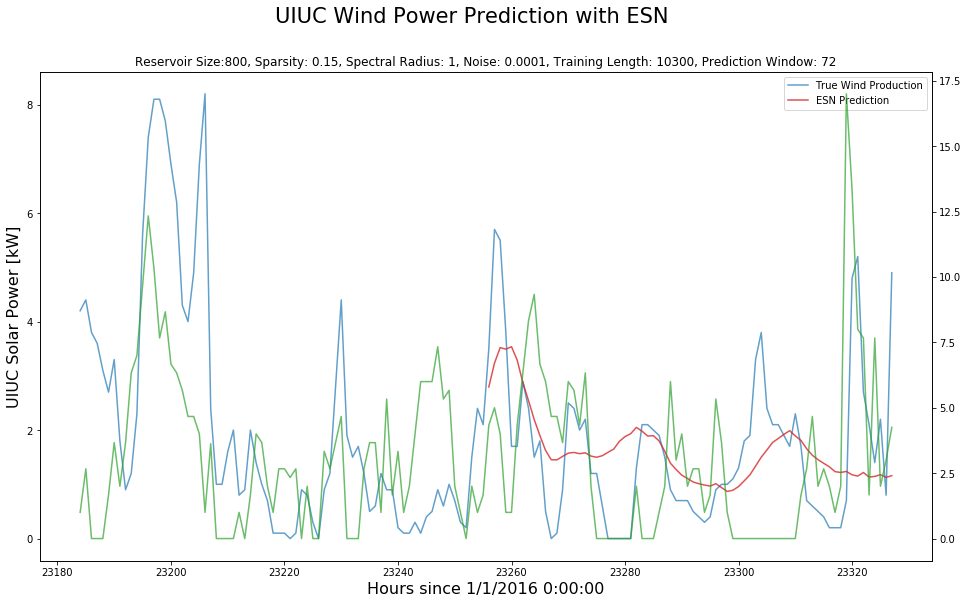

In [30]:
fig, ax = plt.subplots(figsize=(16,9))
fig.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
ax.set_title(param_string(params))
ax.set_ylabel("UIUC Solar Power [kW]", fontsize=16)
ax.set_xlabel("Hours since 1/1/2016 0:00:00", fontsize=16)

# plot the truth
ax.plot(hour_range[-2*futureTotal:],wind_max*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
ax.plot(hour_range[-futureTotal:], wind_max*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
ax2 = ax.twinx()
ax2.plot(hour_range[-2*futureTotal:],windspeed[-2*futureTotal:],'b',label="Wind Speed", 
         alpha=0.7,
         color='tab:green')
ax.legend()
plt.show()

### Notes

After plotting the windspeed at Lincoln Airport versus the wind power produced by Railsplitter Windfarm we note that there are several places where the data doesn't line up. I.e. Railsplitter should not produce any power if the wind isn't blowing. If we want to use windspeed as a training feature, then "nearby" is insufficient. The data must be from the wind farm itself.